In [1]:
import numpy as np
from multiprocessing import cpu_count
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss


In [2]:

# Training data
train_features = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TrainFeat.mat")
train_labels = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TrainLabels.mat")
train_features = train_features['I_x_tr'][0][0]
train_labels = train_labels['I_z_tr'][0][0]

# Testing data
test_features = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TestFeat.mat")
test_labels = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TestLabels.mat")
test_features = test_features['I_x_te'][0][0]
test_labels = test_labels['I_z_te'][0][0]

print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")


Train Features: (17665, 2048), Train Labels: (17665, 291)
Test Features: (1962, 2048), Test Labels: (1962, 291)


In [10]:
# Function to evaluate a model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a multilabel classification model using various metrics.
    Returns a dictionary of evaluation metrics.
    """
    y_pred = model.predict(X_test)
    
    # For multilabel classification
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming = hamming_loss(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'hamming_loss': hamming
    }

In [26]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    Train, evaluate, and save classification models sequentially.
    Returns a dictionary of model performances.
    """
    results = {}
    
    # Scale features
    print("Scaling features...")
    if os.path.exists('scaler.pkl'):
        scaler = joblib.load('scaler.pkl')
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        joblib.dump(scaler, 'scaler.pkl')  # Save the scaler

    # Apply PCA to reduce dimensions
    n_components = 200  # Reduce from 2048 to 100 dimensions
    print(f"Applying PCA to reduce dimensions to {n_components}")
    
    if os.path.exists('pca_model.pkl'):
        pca = joblib.load('pca_model.pkl')
        X_train_reduced = pca.transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)
    else:
        pca = PCA(n_components=n_components)
        X_train_reduced = pca.fit_transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)
        joblib.dump(pca, 'pca_model.pkl')
    
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
    
    
    models = {
        'Linear SVM': OneVsRestClassifier(LinearSVC(max_iter=1)),
        'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=1, n_jobs=1)),
        'Softmax Regression': OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1, n_jobs=1)),
        'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier(
            criterion='gini',  # 'gini' or 'entropy', default is 'gini'
            max_depth=5,  # Limit tree depth to prevent overfitting
            min_samples_split=5,  # Minimum samples to split a node
            min_samples_leaf=2,  # Minimum samples per leaf
            random_state=42  # Ensure reproducibility
        )),
        'Weighted KNN': OneVsRestClassifier(KNeighborsClassifier(
            weights='distance',  
            n_neighbors=5,  
            algorithm='auto',  # Automatically selects the best algorithm
            leaf_size=30,  # Affects speed, default is 30
            p=2,  # p=2 means Euclidean distance
            n_jobs=1  # Single-threaded execution
        ))
    }
    
    trained_models = {}
    
    # for name, model in models.items():
    #     print(f"Training {name}...")
    #     start_time = time.time()
    #     if name == 'Weighted KNN':
    #         # Use PCA reduced data for KNN
    #         model.fit(X_train_reduced, y_train)
    #     else:
    #         model.fit(X_train_scaled, y_train)
    #     training_time = time.time() - start_time
    #     joblib.dump(model, f'{name.replace(" ", "_").lower()}.pkl')  # Save model
        

    
    for name, model in models.items():
        # Evaluate model
        model = joblib.load(f'{name.replace(" ", "_").lower()}.pkl')  # Load model
        if name == 'Weighted KNN':
            metrics = evaluate_model(model, X_test_reduced, y_test)
        else:
           metrics = evaluate_model(model, X_test_scaled, y_test)
        results[name] = {'metrics': metrics, 'training_time': 10}
        print(f"{name} - Accuracy: {metrics['accuracy']:.4f}, "
              f"Precision (Micro): {metrics['precision_micro']:.4f}, "
              f"Precision (Macro): {metrics['precision_macro']:.4f}, "
              f"Recall (Micro): {metrics['recall_micro']:.4f}, "
              f"Recall (Macro): {metrics['recall_macro']:.4f}, "
              f"F1 (Micro): {metrics['f1_micro']:.4f}, "
              f"F1 (Macro): {metrics['f1_macro']:.4f}, "
              f"Hamming Loss: {metrics['hamming_loss']:.4f}, "
              f"Training Time: {results[name]['training_time']:.2f} seconds")
        trained_models[name] = model
    
    # Ensemble model
    print("Training Multilabel Ensemble...")
    start_time = time.time()


    def ensemble_predict(X):
        predictions = np.array([
            trained_models[name].predict(X) if name != 'Weighted KNN' 
            else trained_models['Weighted KNN'].predict(pca.transform(X)) 
            for name in trained_models
        ])
        print(f"Predictions: {predictions}")
        print(f"Predictions shape: {predictions.shape}")
        ensemble_pred = sum(predictions) >= 3  # Majority voting
        return ensemble_pred.astype(int)
    
    print(X_test_scaled.shape)
    y_pred_ensemble = ensemble_predict(X_test_scaled)
    ensemble_time = time.time() - start_time
    print(f"Completed ensemble model in {ensemble_time:.2f} seconds.")
    
    # Calculate metrics for ensemble
    results['Ensemble'] = {
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred_ensemble),
            'precision_micro': precision_score(y_test, y_pred_ensemble, average='micro'),
            'precision_macro': precision_score(y_test, y_pred_ensemble, average='macro'),
            'recall_micro': recall_score(y_test, y_pred_ensemble, average='micro'),
            'recall_macro': recall_score(y_test, y_pred_ensemble, average='macro'),
            'f1_micro': f1_score(y_test, y_pred_ensemble, average='micro'),
            'f1_macro': f1_score(y_test, y_pred_ensemble, average='macro'),
            'hamming_loss': hamming_loss(y_test, y_pred_ensemble)
        },
        'training_time': ensemble_time
    }
    
    return results

In [27]:
# Function to display results
def display_results(results):
    """
    Display the evaluation results in a table and plot the metrics
    """
    # Create a table to display the metrics
    metrics_df = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision (micro)', 'Precision (macro)', 
        'Recall (micro)', 'Recall (macro)', 'F1 (micro)', 'F1 (macro)', 
        'Hamming Loss', 'Training Time (s)'
    ])
    
    i = 0
    for model, data in results.items():
        metrics = data['metrics']
        metrics_df.loc[i] = [
            model,
            f"{metrics['accuracy']:.4f}",
            f"{metrics['precision_micro']:.4f}",
            f"{metrics['precision_macro']:.4f}",
            f"{metrics['recall_micro']:.4f}",
            f"{metrics['recall_macro']:.4f}",
            f"{metrics['f1_micro']:.4f}",
            f"{metrics['f1_macro']:.4f}",
            f"{metrics['hamming_loss']:.4f}",
            f"{data['training_time']:.2f}"
        ]
        i += 1
    
    print("Evaluation Results:")
    print(metrics_df.to_string(index=False))
    
    # Create plots to visualize the metrics
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Extract model names and convert metrics to float
    models = metrics_df['Model']
    accuracy = metrics_df['Accuracy'].astype(float)
    precision_micro = metrics_df['Precision (micro)'].astype(float)
    recall_micro = metrics_df['Recall (micro)'].astype(float)
    f1_micro = metrics_df['F1 (micro)'].astype(float)
    hamming_loss = metrics_df['Hamming Loss'].astype(float)
    training_time = metrics_df['Training Time (s)'].astype(float)
    
    # Accuracy
    axes[0, 0].bar(models, accuracy)
    axes[0, 0].set_title('Accuracy')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Precision (micro)
    axes[0, 1].bar(models, precision_micro)
    axes[0, 1].set_title('Precision (micro)')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Recall (micro)
    axes[0, 2].bar(models, recall_micro)
    axes[0, 2].set_title('Recall (micro)')
    axes[0, 2].set_ylim([0, 1])
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # F1 Score (micro)
    axes[1, 0].bar(models, f1_micro)
    axes[1, 0].set_title('F1 Score (micro)')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Hamming Loss (lower is better)
    axes[1, 1].bar(models, hamming_loss)
    axes[1, 1].set_title('Hamming Loss (lower is better)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Training Time
    axes[1, 2].bar(models, training_time)
    axes[1, 2].set_title('Training Time (seconds)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

Starting Task 0: Classification Algorithms Evaluation
Training and evaluating models...
Scaling features...
Applying PCA to reduce dimensions to 200
Explained variance ratio: 0.72
Linear SVM - Accuracy: 0.0183, Precision (Micro): 0.7566, Precision (Macro): 0.3211, Recall (Micro): 0.2255, Recall (Macro): 0.1026, F1 (Micro): 0.3475, F1 (Macro): 0.1398, Hamming Loss: 0.0164, Training Time: 10.00 seconds
Logistic Regression - Accuracy: 0.0000, Precision (Micro): 0.0704, Precision (Macro): 0.0554, Recall (Micro): 0.8624, Recall (Macro): 0.8201, F1 (Micro): 0.1302, F1 (Macro): 0.0975, Hamming Loss: 0.2230, Training Time: 10.00 seconds
Softmax Regression - Accuracy: 0.0000, Precision (Micro): 0.0704, Precision (Macro): 0.0554, Recall (Micro): 0.8624, Recall (Macro): 0.8201, F1 (Micro): 0.1302, F1 (Macro): 0.0975, Hamming Loss: 0.2230, Training Time: 10.00 seconds
Decision Tree - Accuracy: 0.0102, Precision (Micro): 0.5300, Precision (Macro): 0.3606, Recall (Micro): 0.2440, Recall (Macro): 0.1

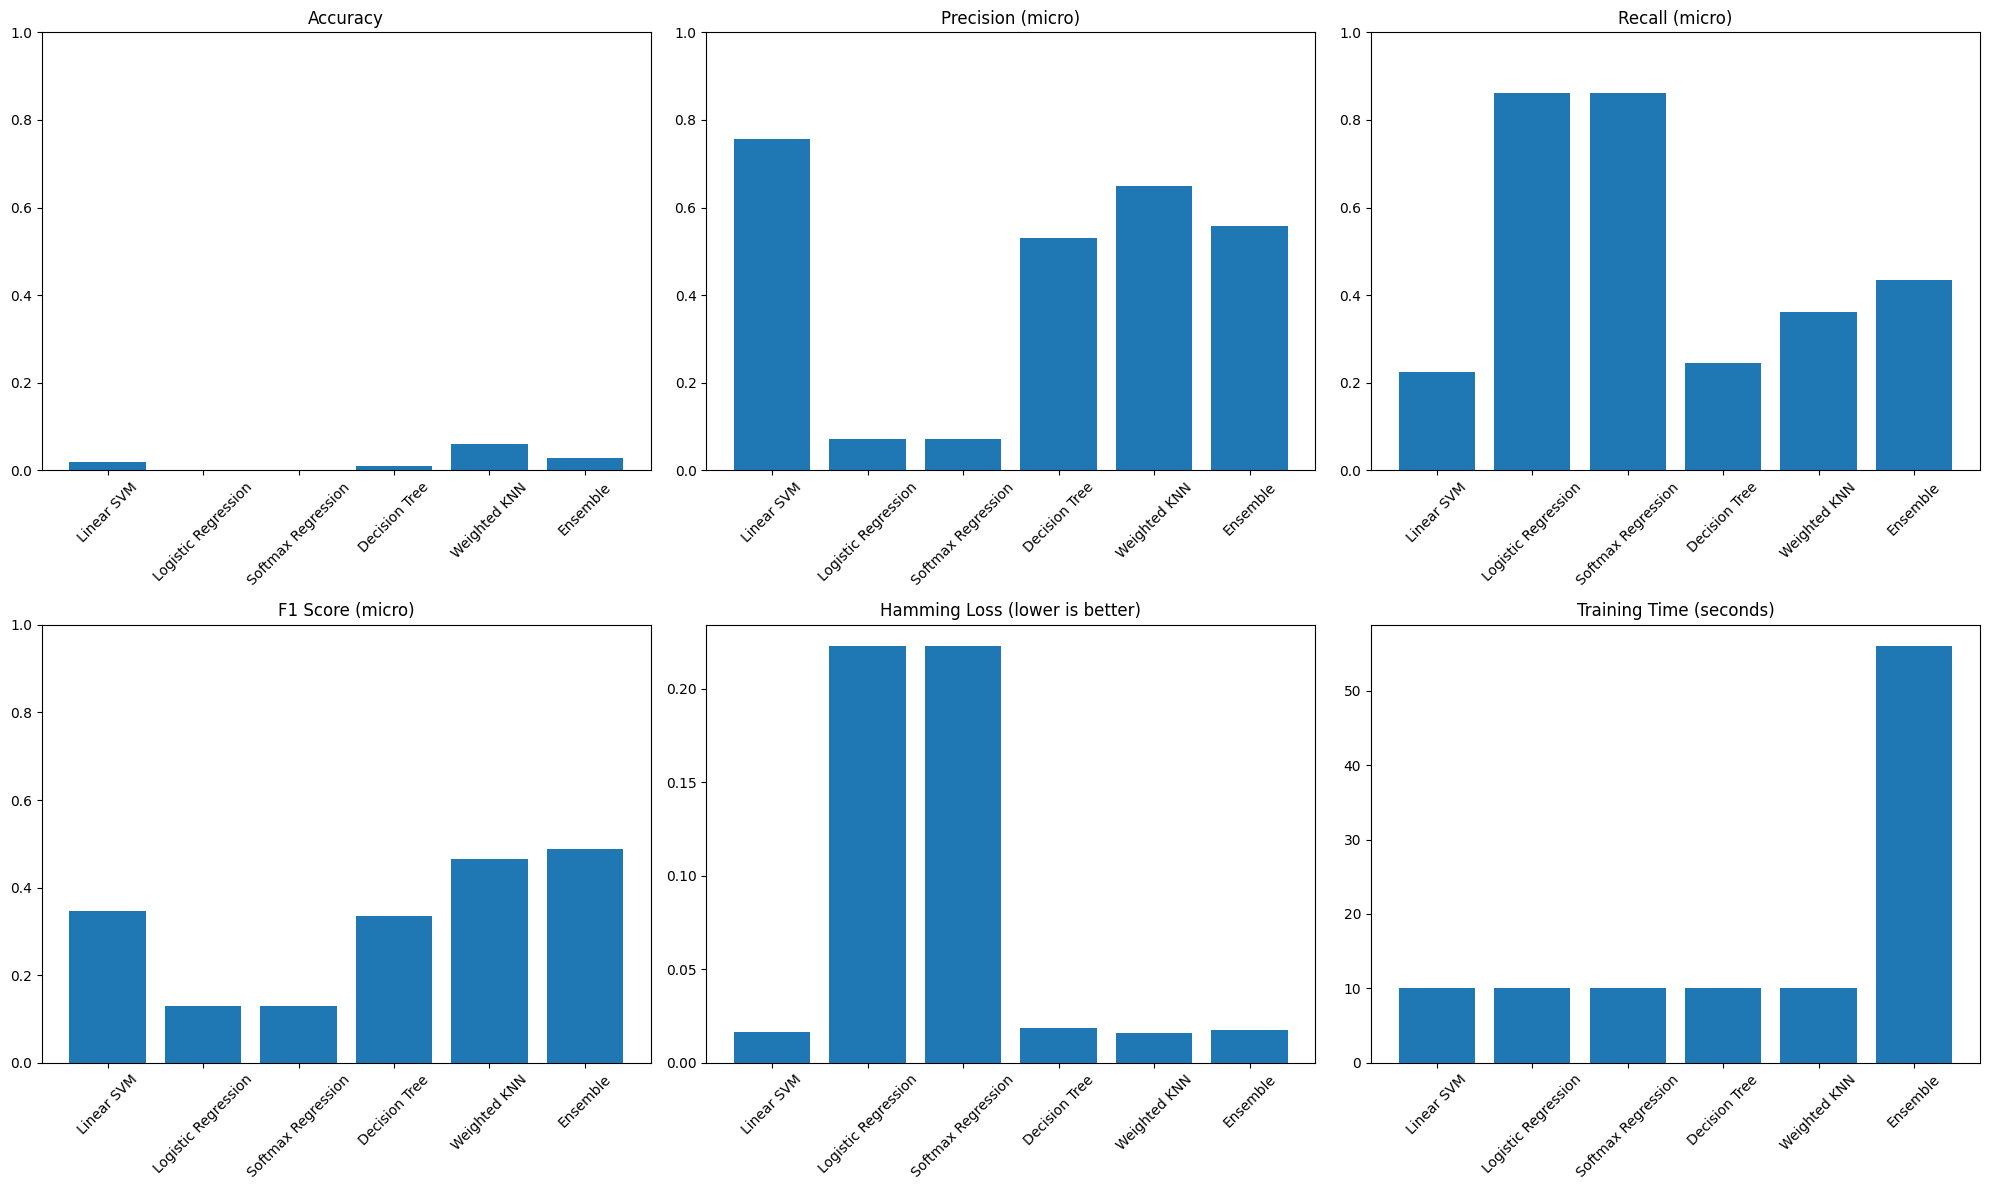

Results saved to classification_results.csv


In [28]:
# Main execution
print("Starting Task 0: Classification Algorithms Evaluation")

# Train and evaluate models
print("Training and evaluating models...")
results = train_and_evaluate_models(train_features, train_labels, test_features, test_labels)

# Display results
display_results(results)

# Save results to CSV
results_df = pd.DataFrame()
for model, data in results.items():
    metrics = data['metrics']
    row = {
        'Model': model,
        'Accuracy': metrics['accuracy'],
        'Precision (micro)': metrics['precision_micro'],
        'Precision (macro)': metrics['precision_macro'],
        'Recall (micro)': metrics['recall_micro'],
        'Recall (macro)': metrics['recall_macro'],
        'F1 (micro)': metrics['f1_micro'],
        'F1 (macro)': metrics['f1_macro'],
        'Hamming Loss': metrics['hamming_loss'],
        'Training Time (s)': data['training_time']
    }
    results_df = pd.concat([results_df, pd.DataFrame([row])])

results_df.to_csv('classification_results.csv', index=False)
print("Results saved to classification_results.csv")

In [4]:
model = joblib.load('logistic_regression.pkl')
scaler = joblib.load('scaler.pkl')
X_test_scaled = scaler.transform(test_features)
y_pred = model.predict(X_test_scaled)


In [30]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0])

In [31]:
test_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=uint8)

In [44]:
matching_indices = np.where((y_pred[0] == 1) & (test_labels[0] == 1) & (y_pred[0] == test_labels[0]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[0])

np.float64(0.9)

In [42]:
matching_indices = np.where((y_pred[1] == 1) & (test_labels[1] == 1) & (y_pred[1] == test_labels[1]))[0]
matching_indices

array([212, 236, 272, 284])

In [43]:
len(matching_indices)/np.sum(test_labels[1])

np.float64(0.4444444444444444)

In [45]:
model = joblib.load('softmax_regression.pkl')

In [46]:
y_pred = model.predict(X_test_scaled)

In [47]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0])

In [48]:
matching_indices = np.where((y_pred[0] == 1) & (test_labels[0] == 1) & (y_pred[0] == test_labels[0]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[0])

np.float64(0.9)

In [49]:
matching_indices = np.where((y_pred[1] == 1) & (test_labels[1] == 1) & (y_pred[1] == test_labels[1]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[1])

np.float64(0.4444444444444444)

In [50]:
model = joblib.load('decision_tree.pkl')
y_pred = model.predict(X_test_scaled)

In [51]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [52]:
matching_indices = np.where((y_pred[0] == 1) & (test_labels[0] == 1) & (y_pred[0] == test_labels[0]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[0])

np.float64(0.3)

In [53]:
matching_indices = np.where((y_pred[1] == 1) & (test_labels[1] == 1) & (y_pred[1] == test_labels[1]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[1])

np.float64(0.1111111111111111)

In [5]:
model = joblib.load('weighted_knn.pkl')
pca = joblib.load('pca_model.pkl')
X_test_reduced = pca.transform(X_test_scaled)


In [6]:
y_pred = model.predict(X_test_reduced)

In [7]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [8]:
matching_indices = np.where((y_pred[0] == 1) & (test_labels[0] == 1) & (y_pred[0] == test_labels[0]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[0])

np.float64(0.3)

In [9]:
matching_indices = np.where((y_pred[1] == 1) & (test_labels[1] == 1) & (y_pred[1] == test_labels[1]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[1])

np.float64(0.1111111111111111)

In [10]:
model = joblib.load('linear_svm.pkl')
y_pred = model.predict(X_test_scaled)

In [11]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [12]:
matching_indices = np.where((y_pred[0] == 1) & (test_labels[0] == 1) & (y_pred[0] == test_labels[0]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[0])

np.float64(0.3)

In [13]:
matching_indices = np.where((y_pred[1] == 1) & (test_labels[1] == 1) & (y_pred[1] == test_labels[1]))[0]
matching_indices
len(matching_indices)/np.sum(test_labels[1])

np.float64(0.2222222222222222)

In [ ]:
def calculate_precision_per_sample(all_predictions, true_labels, threshold=0.5):
    """
    Calculate precision-based accuracy score using majority voting.
    
    Parameters:
    -----------
    all_predictions : list of arrays
        List of model predictions (each array of shape (n_samples, n_labels))
    true_labels : array-like
        Ground truth labels (shape (n_samples, n_labels))
    threshold : float, default=0.5
        Proportion of models required to consider a label as predicted
        
    Returns:
    --------
    precision_scores : array
        Precision score for each sample (TP / actual positives)
    ensemble_predictions : array
        Ensemble predictions after majority voting
    support : array
        Number of actual positive labels for each sample
    """
    # Convert predictions to numpy array if not already
    all_predictions = np.array(all_predictions)
    
    # Stack predictions for easier processing
    stacked_preds = np.stack(all_predictions)
    
    # Get number of models
    n_models = stacked_preds.shape[0]
    
    # Calculate threshold count (number of models needed to vote for a label)
    threshold_count = int(n_models * threshold)
    
    # Apply majority voting
    ensemble_pred = np.sum(stacked_preds, axis=0) >= threshold_count
    ensemble_pred = ensemble_pred.astype(int)
    
    # Calculate precision per sample
    precision_scores = []
    support = []
    
    for i in range(true_labels.shape[0]):
        # Find matching indices (true positives)
        matching = np.where((ensemble_pred[i] == 1) & (true_labels[i] == 1))[0]
        
        # Count actual positives
        actual_positives = np.sum(true_labels[i])
        support.append(actual_positives)
        
        # Calculate precision (TP / actual positives)
        if actual_positives > 0:
            precision = len(matching) / actual_positives
        else:
            precision = 1.0 if np.sum(ensemble_pred[i]) == 0 else 0.0
            
        precision_scores.append(precision)
    
    return np.array(precision_scores), ensemble_pred, np.array(support)

def evaluate_ensemble_precision(trained_models, X_test, y_test, pca=None, threshold=0.5):
    """
    Evaluate ensemble precision using majority voting across all models.
    
    Parameters:
    -----------
    trained_models : dict
        Dictionary of trained models
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    pca : object, optional
        PCA model for KNN
    threshold : float, default=0.5
        Threshold for majority voting
        
    Returns:
    --------
    results : dict
        Dictionary containing evaluation results
    """
    # Get predictions from all models
    all_predictions = []
    model_names = []
    
    print("Getting predictions from all models...")
    for name, model in trained_models.items():
        try:
            if name == 'Weighted KNN' and pca is not None:
                X_test_reduced = pca.transform(X_test)
                y_pred = model.predict(X_test_reduced)
            else:
                y_pred = model.predict(X_test)
                
            all_predictions.append(y_pred)
            model_names.append(name)
            print(f"  Got predictions from {name}")
        except Exception as e:
            print(f"  Error getting predictions from {name}: {e}")
    
    # Calculate precision scores for each sample
    precision_scores, ensemble_pred, support = calculate_precision_per_sample(
        all_predictions, y_test, threshold
    )
    
    # Calculate overall metrics
    mean_precision = np.mean(precision_scores)
    weighted_precision = np.sum(precision_scores * support) / np.sum(support)
    
    # Calculate standard metrics
    accuracy = accuracy_score(y_test, ensemble_pred)
    precision_micro = precision_score(y_test, ensemble_pred, average='micro')
    precision_macro = precision_score(y_test, ensemble_pred, average='macro')
    recall_micro = recall_score(y_test, ensemble_pred, average='micro')
    recall_macro = recall_score(y_test, ensemble_pred, average='macro')
    f1_micro = f1_score(y_test, ensemble_pred, average='micro')
    f1_macro = f1_score(y_test, ensemble_pred, average='macro')
    hamming = hamming_loss(y_test, ensemble_pred)
    
    # Return results
    results = {
        'ensemble_precision_mean': mean_precision,
        'ensemble_precision_weighted': weighted_precision,
        'sample_precision_scores': precision_scores,
        'ensemble_predictions': ensemble_pred,
        'standard_metrics': {
            'accuracy': accuracy,
            'precision_micro': precision_micro,
            'precision_macro': precision_macro,
            'recall_micro': recall_micro,
            'recall_macro': recall_macro,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'hamming_loss': hamming
        },
        'models_used': model_names,
        'voting_threshold': threshold
    }
    
    return results